In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
def dibujar_gantt(ejecuciones):
    """
    Dibuja un diagrama de Gantt.
    
    ejecuciones: Lista de tuplas (PID, inicio, fin)
    """
    fig, ax = plt.subplots(figsize=(10, 3))
    
    colores = {}
    colores_disponibles = plt.cm.get_cmap('tab10').colors
    pid_indices = {}
    
    for idx, (pid, inicio, fin) in enumerate(ejecuciones):
        if pid not in colores:
            colores[pid] = colores_disponibles[len(colores) % len(colores_disponibles)]
        if pid not in pid_indices:
            pid_indices[pid] = len(pid_indices)
        
        duracion = fin - inicio
        ax.broken_barh([(inicio, duracion)], (10 * pid_indices[pid], 9), facecolors=colores[pid])
        ax.text(inicio + duracion / 2, 10 * pid_indices[pid] + 4.5, pid, ha='center', va='center', color='white', fontsize=9, fontweight='bold')
    
    # Configurar eje Y
    ax.set_yticks([10 * i + 4.5 for i in pid_indices.values()])
    ax.set_yticklabels(pid_indices.keys())
    ax.set_xlabel("Ciclos")
    ax.set_title("Diagrama de Gantt")

    # Límites y rejilla
    ax.grid(True)
    ax.set_ylim(0, 10 * len(pid_indices))
    ax.set_xlim(0, max(e[2] for e in ejecuciones) + 1)

    plt.tight_layout()
    plt.show()


/tmp/ipykernel_14602/2776622519.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colores_disponibles = plt.cm.get_cmap('tab10').colors


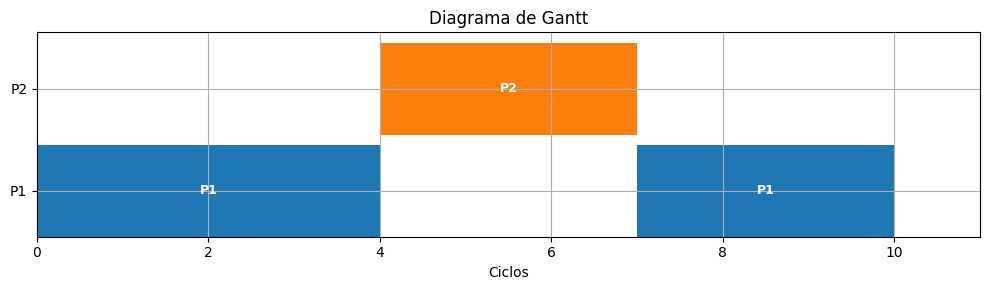

In [3]:
res = [("P1", 0, 4), ("P2", 4, 7), ("P1", 7, 10)]
dibujar_gantt(res)

## File Reader

In [4]:
def read_files(process_path: str, resource_path: str, action_path: str):
    procesos = {}  # PID -> {BT, AT, Priority}
    recursos = {}  # Recurso -> {contador, lectores_activos, escritor_activo}
    acciones_por_ciclo = {}  # Ciclo -> [acciones]

    # Leer procesos
    with open(process_path, 'r') as f:
        for linea in f:
            if linea.strip():
                pid, bt, at, prioridad = map(str.strip, linea.strip().split(','))
                procesos[pid] = {
                    "BT": int(bt),
                    "AT": int(at),
                    "Priority": int(prioridad),
                    "tiempo_restante": int(bt)  # útil para la simulación
                }

    # Leer recursos
    with open(resource_path, 'r') as f:
        for linea in f:
            if linea.strip():
                recurso, contador = map(str.strip, linea.strip().split(','))
                recursos[recurso] = {
                    "contador": int(contador),
                    "lectores_activos": set(),
                    "escritor_activo": None
                }

    # Leer acciones
    with open(action_path, 'r') as f:
        for linea in f:
            if linea.strip():
                pid, accion, recurso, ciclo = map(str.strip, linea.strip().split(','))
                ciclo = int(ciclo)
                if ciclo not in acciones_por_ciclo:
                    acciones_por_ciclo[ciclo] = []
                acciones_por_ciclo[ciclo].append({
                    "PID": pid,
                    "accion": accion.upper(),  # READ o WRITE
                    "recurso": recurso
                })

    return procesos, recursos, acciones_por_ciclo


# Calendarizacion
## First In First Out 

In [5]:
actions_path = "./input/test1/acciones.txt"
process_path = "./input/test1/procesos_sync.txt"
resources_path = "./input/test1/recursos.txt"

res = read_files(process_path=process_path, resource_path=resources_path, action_path=actions_path)
res

({'P1': {'BT': 5, 'AT': 0, 'Priority': 1, 'tiempo_restante': 5},
  'P2': {'BT': 4, 'AT': 1, 'Priority': 2, 'tiempo_restante': 4},
  'P3': {'BT': 6, 'AT': 2, 'Priority': 3, 'tiempo_restante': 6},
  'P4': {'BT': 3, 'AT': 3, 'Priority': 2, 'tiempo_restante': 3},
  'P5': {'BT': 2, 'AT': 4, 'Priority': 1, 'tiempo_restante': 2}},
 {'R1': {'contador': 1, 'lectores_activos': set(), 'escritor_activo': None},
  'R2': {'contador': 2, 'lectores_activos': set(), 'escritor_activo': None},
  'R3': {'contador': 1, 'lectores_activos': set(), 'escritor_activo': None}},
 {0: [{'PID': 'P1', 'accion': 'READ', 'recurso': 'R1'}],
  1: [{'PID': 'P2', 'accion': 'WRITE', 'recurso': 'R2'}],
  2: [{'PID': 'P3', 'accion': 'READ', 'recurso': 'R3'}],
  3: [{'PID': 'P4', 'accion': 'WRITE', 'recurso': 'R1'}],
  4: [{'PID': 'P5', 'accion': 'READ', 'recurso': 'R2'}],
  5: [{'PID': 'P1', 'accion': 'WRITE', 'recurso': 'R2'}],
  6: [{'PID': 'P2', 'accion': 'READ', 'recurso': 'R3'}],
  7: [{'PID': 'P3', 'accion': 'WRITE', '